# Limpieza y Preparación de Datos

## Objetivos de Aprendizaje
- Identificar y manejar datos faltantes
- Detectar y tratar valores atípicos (outliers)
- Eliminar duplicados y normalizar datos
- Validar la calidad de los datos
- Aplicar técnicas de feature engineering básico

## Requisitos
- Python 3.8+
- pandas
- numpy
- matplotlib
- seaborn

In [1]:
# Instalación de dependencias
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scipy -q


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\Luis\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


## 1. Crear Dataset con Problemas de Calidad

Vamos a crear un dataset con varios problemas típicos de calidad.

### 📖 Detectando Problemas de Calidad de Datos

**Los datos del mundo real son SUCIOS:**
- **70-80% del tiempo** en proyectos de datos se gasta en limpieza
- Sin calidad de datos → análisis incorrecto → malas decisiones

**Problemas comunes:**
1. **Valores nulos** (NaN, None, NULL)
2. **Duplicados** (registros repetidos)
3. **Tipos incorrectos** (fechas como strings, números como text)
4. **Outliers** (valores extremos anómalos)
5. **Inconsistencias** (Madrid vs madrid vs MADRID)
6. **Formato incorrecto** (fechas en diferentes formatos)

**Pipeline de inspección:**
```python
df.info()                # Tipos y nulos
df.describe()            # Estadísticas (detectar outliers)
df.isnull().sum()        # Contar nulos por columna
df.duplicated().sum()    # Contar duplicados
df.dtypes                # Verificar tipos
```

Este notebook te enseña a detectar y corregir cada uno de estos problemas.

In [3]:
# Crear dataset con problemas
np.random.seed(42)

n_records = 1000

df_dirty = pd.DataFrame({
    'id': range(1, n_records + 1),
    'nombre': [
        np.random.choice(['  Juan  ', 'MARÍA', 'pedro', 'Ana López', None, 'Carlos', 'Laura '])
        for _ in range(n_records)
    ],
    'email': [
        np.random.choice([
            'juan@email.com', 'maria@test.com', 'invalido', None, 'pedro@example.com',
            'ANA@EMAIL.COM', 'carlos@test', '  laura@email.com  '
        ])
        for _ in range(n_records)
    ],
    'edad': np.random.choice([25, 30, None, -5, 35, 150, 28, 40], n_records),
    'salario': np.random.choice(
        [30000, 45000, None, -1000, 60000, 1000000, 55000, 70000],
        n_records
    ),
    'fecha_registro': pd.date_range('2020-01-01', periods=n_records, freq='D'),
    'ciudad': np.random.choice(['Madrid', 'madrid', 'BARCELONA', 'Barcelona', None], n_records),
    'pais': np.random.choice(['España', 'spain', 'ESPAÑA', None], n_records)
})

# Agregar algunos duplicados
df_dirty = pd.concat([df_dirty, df_dirty.iloc[:10]], ignore_index=True)

print(f"Dataset creado con {len(df_dirty)} registros")
print(f"\nPrimeras filas:")
df_dirty.head(10)

Dataset creado con 1010 registros

Primeras filas:


,id,nombre,email,edad,salario,fecha_registro,ciudad,pais
0,1,Laura,carlos@test,25,45000,2020-01-01,None,spain
1,2,Ana López,maria@test.com,35,30000,2020-01-02,Barcelona,None
2,3,None,invalido,150,55000,2020-01-03,Barcelona,España
3,4,Laura,juan@email.com,28,60000,2020-01-04,BARCELONA,spain
4,5,pedro,pedro@example.com,25,30000,2020-01-05,None,España
5,6,None,pedro@example.com,28,1000000,2020-01-06,Madrid,spain
6,7,None,None,25,70000,2020-01-07,madrid,spain
7,8,Laura,maria@test.com,25,60000,2020-01-08,Barcelona,España
8,9,MARÍA,laura@email.com,40,55000,2020-01-09,madrid,None
9,10,pedro,juan@email.com,-5,None,2020-01-10,Madrid,None


## 2. Análisis Exploratorio de Problemas de Calidad

In [4]:
# Información general
print("=== INFORMACIÓN DEL DATASET ===")
print(f"\nShape: {df_dirty.shape}")
print(f"\nColumnas: {df_dirty.columns.tolist()}")
print(f"\nTipos de datos:")
print(df_dirty.dtypes)

print(f"\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
df_dirty.describe()

=== INFORMACIÓN DEL DATASET ===

Shape: (1010, 8)

Columnas: ['id', 'nombre', 'email', 'edad', 'salario', 'fecha_registro', 'ciudad', 'pais']

Tipos de datos:
id                         int64
nombre                    object
email                     object
edad                      object
salario                   object
fecha_registro    datetime64[ns]
ciudad                    object
pais                      object
dtype: object

=== ESTADÍSTICAS DESCRIPTIVAS ===


,id,fecha_registro
count,1010.000000,1010
mean,495.599010,2021-05-09 14:22:34.455445504
min,1.000000,2020-01-01 00:00:00
25%,243.250000,2020-08-30 06:00:00
50%,495.500000,2021-05-09 12:00:00
75%,747.750000,2022-01-16 18:00:00
max,1000.000000,2022-09-26 00:00:00
std,291.537945,NaN


### 📊 Análisis Exploratorio de Datos (EDA)

**Concepto:** Antes de limpiar datos, debemos entender qué problemas existen mediante un análisis exploratorio.

**Técnicas clave:**
- `info()`: estructura, tipos de datos, valores no nulos
- `describe()`: estadísticas descriptivas de columnas numéricas
- `shape`: dimensiones del dataset (filas, columnas)
- `dtypes`: tipos de datos de cada columna

**Objetivo:** Identificar patrones, anomalías y problemas de calidad antes de aplicar transformaciones.

=== VALORES NULOS ===
         Nulos  Porcentaje
nombre     151       14.95
email      108       10.69
edad       118       11.68
salario    105       10.40
ciudad     203       20.10
pais       236       23.37


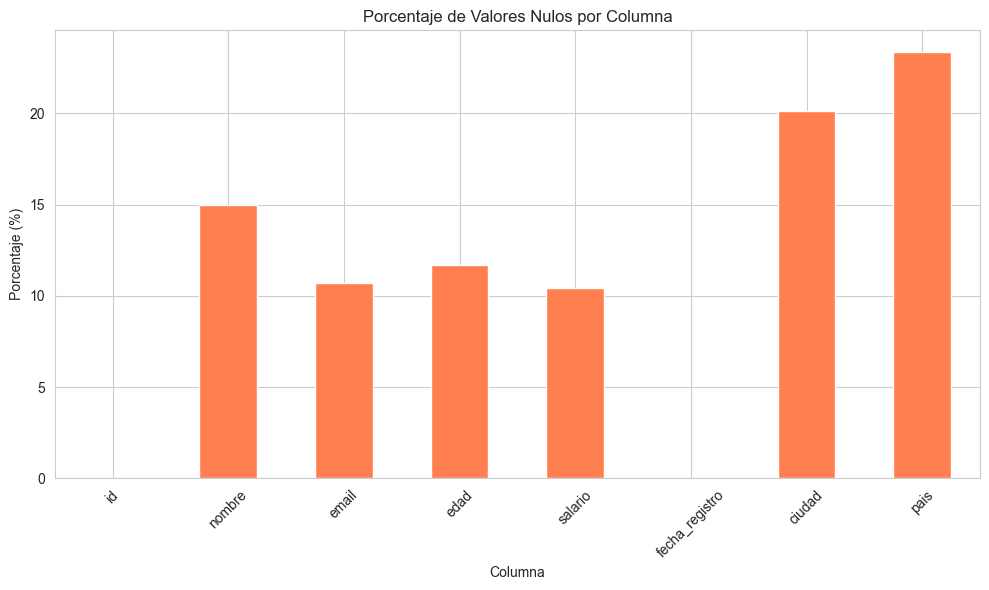

In [5]:
# Análisis de valores nulos
print("=== VALORES NULOS ===")
null_counts = df_dirty.isnull().sum()
null_percentages = (null_counts / len(df_dirty) * 100).round(2)

null_summary = pd.DataFrame({
    'Nulos': null_counts,
    'Porcentaje': null_percentages
})

print(null_summary[null_summary['Nulos'] > 0])

# Visualización
plt.figure(figsize=(10, 6))
null_summary['Porcentaje'].plot(kind='bar', color='coral')
plt.title('Porcentaje de Valores Nulos por Columna')
plt.ylabel('Porcentaje (%)')
plt.xlabel('Columna')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🔍 Detección de Valores Nulos

**Concepto:** Los valores nulos (NaN, None, NULL) representan ausencia de datos y pueden afectar análisis y modelos.

**Métodos importantes:**
- `isnull()` / `isna()`: detecta valores nulos
- `sum()`: cuenta nulos por columna
- Porcentajes ayudan a decidir si eliminar o imputar

**Buena práctica:** Visualizar el porcentaje de nulos por columna para priorizar acciones de limpieza.

In [6]:
# Análisis de duplicados
print("=== ANÁLISIS DE DUPLICADOS ===")
duplicates = df_dirty.duplicated()
print(f"\nTotal de filas duplicadas: {duplicates.sum()}")
print(f"Porcentaje: {(duplicates.sum() / len(df_dirty) * 100):.2f}%")

if duplicates.sum() > 0:
    print(f"\nEjemplos de duplicados:")
    print(df_dirty[duplicates].head())

=== ANÁLISIS DE DUPLICADOS ===

Total de filas duplicadas: 10
Porcentaje: 0.99%

Ejemplos de duplicados:
      id     nombre              email edad salario fecha_registro     ciudad  \
1000   1     Laura         carlos@test   25   45000     2020-01-01       None   
1001   2  Ana López     maria@test.com   35   30000     2020-01-02  Barcelona   
1002   3       None           invalido  150   55000     2020-01-03  Barcelona   
1003   4     Laura      juan@email.com   28   60000     2020-01-04  BARCELONA   
1004   5      pedro  pedro@example.com   25   30000     2020-01-05       None   

        pais  
1000   spain  
1001    None  
1002  España  
1003   spain  
1004  España  


### 🔄 Detección de Duplicados

**Concepto:** Registros duplicados distorsionan estadísticas y análisis, generando sesgo en los resultados.

**Método clave:**
- `duplicated()`: retorna boolean indicando si una fila es duplicado
- Por defecto considera todas las columnas
- Puede configurarse con `subset=` para columnas específicas

**Decisión:** Antes de eliminar, verificar si los duplicados son errores reales o datos legítimos.

## 3. Limpieza de Datos Paso a Paso

In [7]:
# Crear copia para limpiar
df_clean = df_dirty.copy()

print(f"Dataset original: {len(df_dirty)} filas")
print(f"Iniciando limpieza...")

Dataset original: 1010 filas
Iniciando limpieza...


### 3.1. Eliminar Duplicados

In [8]:
# Eliminar duplicados completos
before = len(df_clean)
df_clean = df_clean.drop_duplicates()
after = len(df_clean)

print(f"Duplicados eliminados: {before - after}")
print(f"Registros restantes: {after}")

Duplicados eliminados: 10
Registros restantes: 1000


### ✂️ Eliminación de Duplicados

**Concepto:** `drop_duplicates()` elimina filas duplicadas, manteniendo la primera ocurrencia por defecto.

**Parámetros importantes:**
- `subset=`: especifica columnas para evaluar duplicación
- `keep='first'|'last'|False`: qué duplicado mantener
- `inplace=True`: modifica el DataFrame original

**Impacto:** Reduce ruido y mejora calidad de datos, especialmente en agregaciones.

### 3.2. Limpiar Columnas de Texto

In [9]:
# Limpiar nombres
print("=== LIMPIEZA DE NOMBRES ===")
print("\nAntes:")
print(df_clean['nombre'].value_counts())

# Aplicar limpieza
df_clean['nombre'] = df_clean['nombre'].str.strip().str.title()

print("\nDespués:")
print(df_clean['nombre'].value_counts())

=== LIMPIEZA DE NOMBRES ===

Antes:
nombre
Ana López    156
  Juan       156
Laura        138
MARÍA        137
Carlos       135
pedro        130
Name: count, dtype: int64

Después:
nombre
Ana López    156
Juan         156
Laura        138
María        137
Carlos       135
Pedro        130
Name: count, dtype: int64


### 🔤 Limpieza de Datos de Texto

**Concepto:** Datos de texto requieren normalización para estandarizar formatos y facilitar análisis.

**Operaciones comunes:**
- `str.strip()`: elimina espacios al inicio y final
- `str.title()`: capitaliza primera letra de cada palabra
- `str.lower()` / `str.upper()`: conversión de mayúsculas/minúsculas
- `str.replace()`: reemplaza patrones de texto

**Uso:** Esencial para nombres, direcciones, categorías y cualquier campo de texto libre.

In [10]:
# Limpiar emails
print("=== LIMPIEZA DE EMAILS ===")

# Normalizar: quitar espacios y convertir a minúsculas
df_clean['email'] = df_clean['email'].str.strip().str.lower()

# Validar formato de email
import re
email_pattern = r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'

def is_valid_email(email):
    if pd.isna(email):
        return False
    return bool(re.match(email_pattern, email))

df_clean['email_valido'] = df_clean['email'].apply(is_valid_email)

print(f"\nEmails válidos: {df_clean['email_valido'].sum()}")
print(f"Emails inválidos: {(~df_clean['email_valido']).sum()}")

print("\nEjemplos de emails inválidos:")
print(df_clean[~df_clean['email_valido']]['email'].value_counts())

=== LIMPIEZA DE EMAILS ===

Emails válidos: 631
Emails inválidos: 369

Ejemplos de emails inválidos:
email
carlos@test    132
invalido       130
Name: count, dtype: int64


### 📧 Validación de Formatos con Regex

**Concepto:** Las expresiones regulares (regex) permiten validar patrones complejos como emails, teléfonos, URLs.

**Patrón email:** `^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$`
- `^`: inicio de string
- `[...]+`: uno o más caracteres permitidos
- `@`: arroba obligatoria
- `\.`: punto literal (escapado)
- `{2,}`: mínimo 2 caracteres para dominio

**Uso:** Crear columnas booleanas indicando validez facilita filtrado y análisis de calidad.

In [11]:
# Normalizar ciudades y países
print("=== NORMALIZACIÓN DE CIUDADES Y PAÍSES ===")

# Ciudades
df_clean['ciudad'] = df_clean['ciudad'].str.strip().str.title()
print("\nCiudades únicas:")
print(df_clean['ciudad'].value_counts())

# Países
df_clean['pais'] = df_clean['pais'].str.strip().str.title()
print("\nPaíses únicos:")
print(df_clean['pais'].value_counts())

=== NORMALIZACIÓN DE CIUDADES Y PAÍSES ===

Ciudades únicas:
ciudad
Barcelona    427
Madrid       372
Name: count, dtype: int64

Países únicos:
pais
España    527
Spain     240
Name: count, dtype: int64


### 3.3. Limpiar Datos Numéricos

=== ANÁLISIS DE EDAD ===

Estadísticas:
count    882.000000
mean      42.120181
std       44.946876
min       -5.000000
25%       25.000000
50%       30.000000
75%       40.000000
max      150.000000
Name: edad, dtype: float64


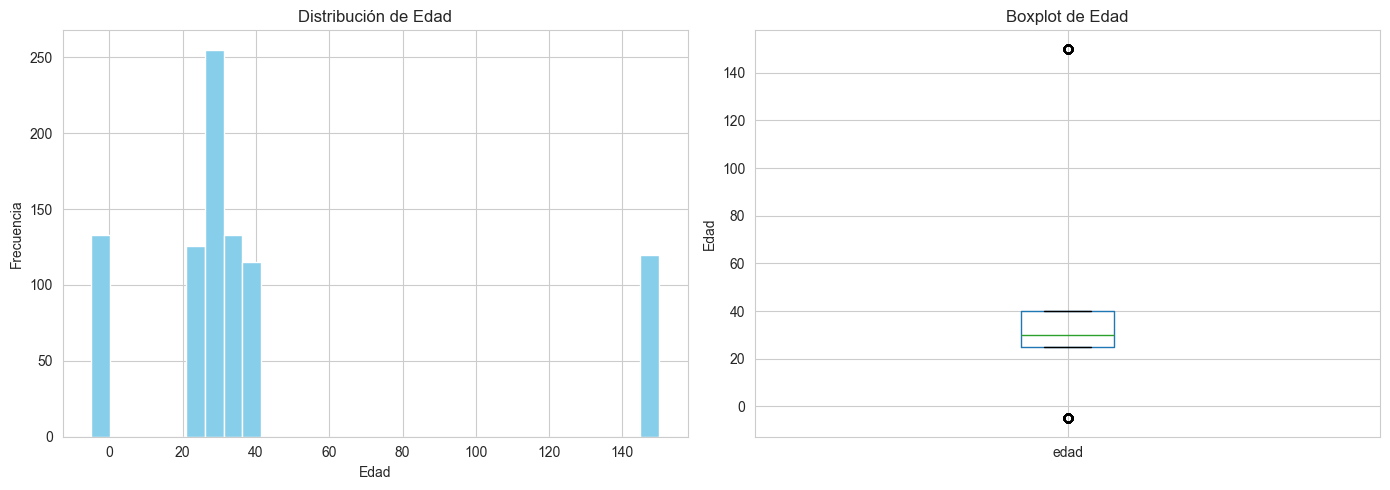


Valores negativos: 133
Valores > 100: 120
Valores nulos: 118


In [13]:
# Analizar edad
print("=== ANÁLISIS DE EDAD ===")

# Convertir edad a numérico (por si viene como object)
df_clean['edad'] = pd.to_numeric(df_clean['edad'], errors='coerce')

print(f"\nEstadísticas:")
print(df_clean['edad'].describe())

# Visualizar distribución
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
df_clean['edad'].hist(bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Edad')
axes[0].set_xlabel('Edad')
axes[0].set_ylabel('Frecuencia')

# Boxplot
df_clean.boxplot(column='edad', ax=axes[1])
axes[1].set_title('Boxplot de Edad')
axes[1].set_ylabel('Edad')

plt.tight_layout()
plt.show()

# Identificar valores problemáticos
print(f"\nValores negativos: {(df_clean['edad'] < 0).sum()}")
print(f"Valores > 100: {(df_clean['edad'] > 100).sum()}")
print(f"Valores nulos: {df_clean['edad'].isnull().sum()}")

### 📈 Análisis de Outliers en Datos Numéricos

**Concepto:** Los outliers (valores atípicos) son observaciones que se desvían significativamente del resto.

**Técnicas de detección:**
- **Histograma:** muestra distribución completa de valores
- **Boxplot:** identifica valores fuera del rango IQR (Q1-1.5*IQR, Q3+1.5*IQR)
- **Estadísticas:** min, max, percentiles revelan valores extremos

**Decisiones:**
- ¿Son errores de captura? → Eliminar o corregir
- ¿Son valores legítimos? → Mantener pero documentar
- ¿Afectan el análisis? → Considerar transformaciones o tratamiento especial

In [14]:
# Limpiar edad: establecer límites razonables
print("=== LIMPIEZA DE EDAD ===")

# Convertir valores fuera de rango a NaN
df_clean.loc[(df_clean['edad'] < 18) | (df_clean['edad'] > 100), 'edad'] = np.nan

# Imputar valores faltantes con la mediana
mediana_edad = df_clean['edad'].median()
df_clean['edad'].fillna(mediana_edad, inplace=True)

print(f"\nValores imputados con mediana: {mediana_edad}")
print(f"\nNueva distribución:")
print(df_clean['edad'].describe())

=== LIMPIEZA DE EDAD ===

Valores imputados con mediana: 30.0

Nueva distribución:
count    1000.000000
mean       30.945000
std         4.192798
min        25.000000
25%        30.000000
50%        30.000000
75%        30.000000
max        40.000000
Name: edad, dtype: float64


### 🔧 Imputación de Valores Faltantes

**Concepto:** Imputar significa reemplazar valores nulos con valores estimados para no perder datos.

**Estrategias comunes:**
- **Media:** `mean()` - sensible a outliers, buena para distribuciones normales
- **Mediana:** `median()` - robusta a outliers, recomendada para datos sesgados
- **Moda:** `mode()` - para datos categóricos
- **Forward/Backward Fill:** para series temporales
- **Modelos predictivos:** ML avanzado para imputación

**Elección:** Depende de la distribución de datos y del contexto del negocio.

=== ANÁLISIS DE SALARIO ===

Estadísticas:
count        896.000000
mean      184863.839286
std       341228.122696
min        -1000.000000
25%        30000.000000
50%        55000.000000
75%        70000.000000
max      1000000.000000
Name: salario, dtype: float64

Rango IQR:
  Límite inferior: -30,000.00
  Límite superior: 130,000.00

Outliers detectados: 133


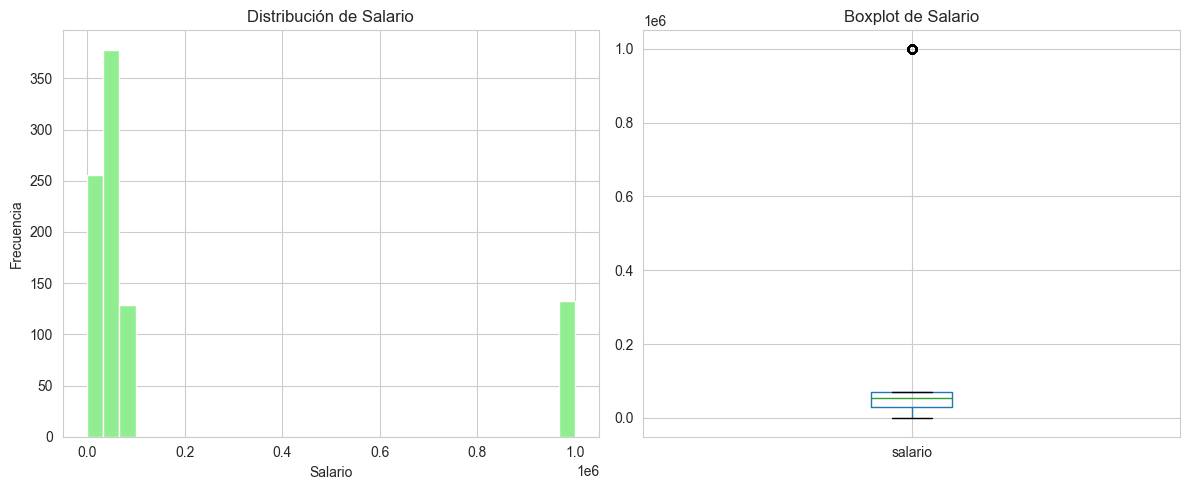

In [16]:
# Limpiar salario
print("=== ANÁLISIS DE SALARIO ===")

# Convertir salario a numérico (por si viene como object)
df_clean['salario'] = pd.to_numeric(df_clean['salario'], errors='coerce')

print(f"\nEstadísticas:")
print(df_clean['salario'].describe())

# Identificar outliers con IQR
Q1 = df_clean['salario'].quantile(0.25)
Q3 = df_clean['salario'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"\nRango IQR:")
print(f"  Límite inferior: {limite_inferior:,.2f}")
print(f"  Límite superior: {limite_superior:,.2f}")

outliers = df_clean[(df_clean['salario'] < limite_inferior) | (df_clean['salario'] > limite_superior)]
print(f"\nOutliers detectados: {len(outliers)}")

# Visualizar
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_clean['salario'].hist(bins=30, color='lightgreen')
plt.title('Distribución de Salario')
plt.xlabel('Salario')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='salario')
plt.title('Boxplot de Salario')

plt.tight_layout()
plt.show()

### 📊 Método IQR para Detección de Outliers

**Concepto:** El Rango Intercuartílico (IQR) es una medida robusta para identificar valores atípicos.

**Cálculo:**
- IQR = Q3 - Q1 (diferencia entre cuartil 75 y cuartil 25)
- Límite inferior = Q1 - 1.5 × IQR
- Límite superior = Q3 + 1.5 × IQR
- Valores fuera de estos límites se consideran outliers

**Ventaja:** Menos sensible a valores extremos que métodos basados en desviación estándar.

**Uso:** Estándar en data science para limpieza de datos numéricos antes de modelado.

In [17]:
# Limpiar salario
print("=== LIMPIEZA DE SALARIO ===")

# Convertir valores negativos y outliers extremos a NaN
df_clean.loc[(df_clean['salario'] < 0) | (df_clean['salario'] > 200000), 'salario'] = np.nan

# Imputar con la mediana
mediana_salario = df_clean['salario'].median()
df_clean['salario'].fillna(mediana_salario, inplace=True)

print(f"\nValores imputados con mediana: ${mediana_salario:,.2f}")
print(f"\nNueva distribución:")
print(df_clean['salario'].describe())

=== LIMPIEZA DE SALARIO ===

Valores imputados con mediana: $55,000.00

Nueva distribución:
count     1000.000000
mean     53345.000000
std      10812.163423
min      30000.000000
25%      55000.000000
50%      55000.000000
75%      60000.000000
max      70000.000000
Name: salario, dtype: float64


### 3.4. Validación de Datos Limpios

In [18]:
# Crear reporte de calidad
print("=== REPORTE DE CALIDAD DE DATOS ===")

quality_report = pd.DataFrame({
    'Columna': df_clean.columns,
    'Tipo': df_clean.dtypes.values,
    'Nulos': df_clean.isnull().sum().values,
    '% Nulos': (df_clean.isnull().sum() / len(df_clean) * 100).values.round(2),
    'Únicos': [df_clean[col].nunique() for col in df_clean.columns]
})

print(quality_report)

=== REPORTE DE CALIDAD DE DATOS ===
          Columna            Tipo  Nulos  % Nulos  Únicos
0              id           int64      0      0.0    1000
1          nombre          object    148     14.8       6
2           email          object    107     10.7       7
3            edad         float64      0      0.0       5
4         salario         float64      0      0.0       5
5  fecha_registro  datetime64[ns]      0      0.0    1000
6          ciudad          object    201     20.1       2
7            pais          object    233     23.3       2
8    email_valido            bool      0      0.0       2


### ✅ Reporte de Calidad de Datos

**Concepto:** Un reporte de calidad resume el estado del dataset tras la limpieza.

**Métricas clave:**
- **Tipo de dato:** verifica conversiones correctas
- **Nulos:** identifica columnas con datos faltantes restantes
- **Únicos:** evalúa cardinalidad y posibles errores de captura
- **Porcentaje nulos:** prioriza columnas problemáticas

**Objetivo:** Documentar la calidad final y detectar problemas residuales antes de análisis o modelado.

In [19]:
# Comparación antes y después
print("=== COMPARACIÓN ANTES Y DESPUÉS ===")
print(f"\nRegistros originales: {len(df_dirty)}")
print(f"Registros limpios: {len(df_clean)}")
print(f"Registros eliminados: {len(df_dirty) - len(df_clean)}")

print(f"\nValores nulos originales: {df_dirty.isnull().sum().sum()}")
print(f"Valores nulos después: {df_clean.isnull().sum().sum()}")

=== COMPARACIÓN ANTES Y DESPUÉS ===

Registros originales: 1010
Registros limpios: 1000
Registros eliminados: 10

Valores nulos originales: 921
Valores nulos después: 689


## 4. Feature Engineering Básico

In [20]:
# Crear nuevas características
print("=== FEATURE ENGINEERING ===")

# Categoría de edad
df_clean['categoria_edad'] = pd.cut(
    df_clean['edad'],
    bins=[0, 25, 35, 50, 100],
    labels=['18-25', '26-35', '36-50', '51+']
)

# Categoría de salario
df_clean['categoria_salario'] = pd.cut(
    df_clean['salario'],
    bins=[0, 40000, 60000, 100000],
    labels=['Bajo', 'Medio', 'Alto']
)

# Extraer componentes de fecha
df_clean['año_registro'] = df_clean['fecha_registro'].dt.year
df_clean['mes_registro'] = df_clean['fecha_registro'].dt.month
df_clean['dias_desde_registro'] = (datetime.now() - df_clean['fecha_registro']).dt.days

print("\nNuevas características creadas:")
print(df_clean[[
    'edad', 'categoria_edad',
    'salario', 'categoria_salario',
    'fecha_registro', 'dias_desde_registro'
]].head())

=== FEATURE ENGINEERING ===

Nuevas características creadas:
   edad categoria_edad  salario categoria_salario fecha_registro  \
0  25.0          18-25  45000.0             Medio     2020-01-01   
1  35.0          26-35  30000.0              Bajo     2020-01-02   
2  30.0          26-35  55000.0             Medio     2020-01-03   
3  28.0          26-35  60000.0             Medio     2020-01-04   
4  25.0          18-25  30000.0              Bajo     2020-01-05   

   dias_desde_registro  
0                 2167  
1                 2166  
2                 2165  
3                 2164  
4                 2163  


### 🔨 Feature Engineering: Creación de Variables

**Concepto:** Feature Engineering es crear nuevas características a partir de datos existentes para mejorar análisis.

**Técnicas aplicadas:**
1. **Binning/Discretización:** `pd.cut()` convierte variables continuas en categorías
2. **Extracción temporal:** `.dt.year`, `.dt.month` extraen componentes de fechas
3. **Cálculo de diferencias:** días desde un evento, tiempo transcurrido

**Beneficios:**
- Facilita interpretación de análisis
- Mejora rendimiento de modelos de ML
- Descubre patrones ocultos en los datos

**Nota:** Este es el puente entre limpieza de datos y análisis avanzado.

## 5. Exportar Datos Limpios

In [21]:
# Guardar dataset limpio
output_path = '../../datasets/processed/datos_limpios.csv'
df_clean.to_csv(output_path, index=False)

print(f"Dataset limpio guardado en: {output_path}")
print(f"\nShape final: {df_clean.shape}")
print(f"\nColumnas finales:")
print(df_clean.columns.tolist())

Dataset limpio guardado en: ../../datasets/processed/datos_limpios.csv

Shape final: (1000, 14)

Columnas finales:
['id', 'nombre', 'email', 'edad', 'salario', 'fecha_registro', 'ciudad', 'pais', 'email_valido', 'categoria_edad', 'categoria_salario', 'año_registro', 'mes_registro', 'dias_desde_registro']


### 💾 Exportación de Datos Procesados

**Concepto:** Guardar datos limpios para reutilización sin repetir todo el proceso de limpieza.

**Formato CSV:**
- Universal y legible por humanos
- `index=False`: evita guardar índice como columna
- Compresión opcional: `compression='gzip'` para datasets grandes

**Buenas prácticas:**
- Guardar en carpeta `processed/` separada de datos `raw/`
- Mantener datos originales intactos (trazabilidad)
- Documentar transformaciones aplicadas (metadatos)

**Próximo paso:** Datos listos para análisis exploratorio, visualización o modelado.

## Resumen y Mejores Prácticas

### Proceso de Limpieza:
1. **Análisis exploratorio**: Identificar problemas de calidad
2. **Eliminar duplicados**: Asegurar unicidad de registros
3. **Normalizar texto**: Estandarizar formato de strings
4. **Validar datos**: Verificar rangos y formatos
5. **Manejar outliers**: Detectar y tratar valores atípicos
6. **Imputar valores faltantes**: Estrategia según el contexto
7. **Feature engineering**: Crear características derivadas

### Mejores Prácticas:
- Siempre trabajar en una copia del dataset original
- Documentar cada paso de limpieza
- Validar resultados después de cada transformación
- Considerar el contexto del negocio para decisiones de limpieza
- Automatizar el proceso con funciones reutilizables
- Mantener registro de cambios (auditoría)

### Técnicas de Imputación:
- **Media/Mediana**: Para datos numéricos
- **Moda**: Para datos categóricos
- **Forward/Backward fill**: Para series temporales
- **Interpolación**: Para datos secuenciales
- **Valor constante**: Cuando tiene sentido de negocio

### Recursos Adicionales:
- [Pandas Data Cleaning](https://pandas.pydata.org/docs/user_guide/missing_data.html)
- [Data Quality Best Practices](https://www.dataversity.net/data-quality-best-practices/)
- [Feature Engineering Guide](https://www.kaggle.com/learn/feature-engineering)

---

## 🧭 Navegación

**← Anterior:** [SQL Básico para Ingeniería de Datos](04_sql_basico.ipynb)

**Siguiente →:** [📊 Visualización de Datos en Ingeniería de Datos →](06_visualizacion_datos.ipynb)

**📚 Índice de Nivel Junior:**
- [📊 Junior - 01. Introducción a la Ingeniería de Datos](01_introduccion_ingenieria_datos.ipynb)
- [🐍 Junior - 02. Python para Manipulación de Datos](02_python_manipulacion_datos.ipynb)
- [Pandas: Fundamentos para Análisis de Datos](03_pandas_fundamentos.ipynb)
- [SQL Básico para Ingeniería de Datos](04_sql_basico.ipynb)
- [Limpieza y Preparación de Datos](05_limpieza_datos.ipynb) ← 🔵 Estás aquí
- [📊 Visualización de Datos en Ingeniería de Datos](06_visualizacion_datos.ipynb)
- [🔄 Git y Control de Versiones para Ingeniería de Datos](07_git_control_versiones.ipynb)
- [🌐 APIs REST y Web Scraping para Ingeniería de Datos](08_apis_web_scraping.ipynb)
- [🎯 Proyecto Integrador 1: Pipeline ETL Completo](09_proyecto_integrador_1.ipynb)
- [🚀 Proyecto Integrador 2: Pipeline Near Real-Time, Scheduling y Alertas](10_proyecto_integrador_2.ipynb)

**🎓 Otros Niveles:**
- [Nivel Junior](../nivel_junior/README.md)
- [Nivel Mid](../nivel_mid/README.md)
- [Nivel Senior](../nivel_senior/README.md)
- [Nivel GenAI](../nivel_genai/README.md)
- [Negocio LATAM](../negocios_latam/README.md)
